In [66]:
#optimizing the parameters of XCDM model(flat) by minimizing the chi-squared value

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

#data of H_obs,z_obs,sigma_obs 

H_obs = np.array([69,69,68.6,83,75,75,72.9,77,88.8,83,83,95,77,87.1,92.8,89,80.9,97,104,92,105,125,90,117,154,168,160,177,140,202,186.5])
z_obs = np.array([0.07,0.09,0.12,0.17,0.179,0.199,0.2,0.27,0.28,0.352,0.3802,0.4,0.4004,0.4247,0.4497,0.47,0.4783,0.48,0.593,0.68,0.781,0.875,0.88,0.9,1.037,1.3,1.363,1.43,1.53,1.75,1.965])
sigma_obs = np.array([19.6,12,26.2,8,4,5,29.6,14,36.6,14,13.5,17,10.2,11.2,12.9,50,9,62,13,8,12,17,40,23,20,17,33.6,18,14,40,50.4])
z_obs1 = np.array([0.380,0.380,0.510,0.510,0.610,0.610,0.122,0.810,1.520,2.340,2.340])
D_obs = np.array([1512.3900,81.2087,1975.2200,90.9029,2306.6800,98.9647,539.0000,10.7500,3843.0000,8.8600,37.4100])
c = 3*10**5
omega_bh2 = 0.02229
omega_vo = 0.0014

In [68]:
def H_model( z,parameters):
    omega_mo,wx,Ho = parameters
    H_model= Ho*np.sqrt(omega_mo*(1+z)**3 +(1-omega_mo)*((1+z)**(3*(1+wx))))
     #print("H_model1:", H_model)
    return H_model

In [70]:
def chi_sq1( parameters,H_obs,z_obs,sigma_obs):
    n = z_obs.shape[0]
    H_theo = np.zeros(n)
    omega_mo,wx,Ho = parameters
    chi_sq = 0
    for i in range(n):
        H_theo[i]= H_model( z_obs[i],parameters)
        #print("H_obs, H_theo:", H_obs[i], H_theo[i])
        chi_sq = chi_sq + (H_obs[i] - H_theo[i])**2/(sigma_obs[i])**2
    return chi_sq

In [72]:
initial = np.array([0.3,-1,70])
soln = minimize( chi_sq1 ,initial,args=( H_obs,z_obs,sigma_obs),bounds=[(0,1),(-2,0),(0,np.inf)])
print("Optimal Parameters:", soln.x)
print("Convergence:", soln.success)

Optimal Parameters: [ 0.32230621 -1.24974723 70.8207098 ]
Convergence: True


In [74]:
initial = np.array([0.3,-1,70])
soln = minimize( chi_sq1 ,initial,args=( H_obs,z_obs,sigma_obs),bounds=[(0,1),(-2,0),(0,np.inf)])
print(soln)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 14.360643778265583
        x: [ 3.223e-01 -1.250e+00  7.082e+01]
      nit: 19
      jac: [ 2.289e-03  7.530e-04  8.065e-05]
     nfev: 92
     njev: 23
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


In [76]:
from scipy import integrate
#E(z)= np.sqrt(omega_mo*(1+z)**3 + (1-omega_mo))
#H(z) or H_model = Ho*E(z)
# f= 1/E(z)
def f(z,parameters):
    omega_mo,wx,Ho = parameters
    return 1.0/np.sqrt(omega_mo*(1+z)**3 +(1-omega_mo)*((1+z)**(3*(1+wx))))
def dM(z,parameters):
    omega_mo,wx,Ho = parameters 
    return (c/Ho)*integrate.quad(f,0,z,args=(parameters))[0]
def dV(z,parameters):
    omega_mo,wx,Ho = parameters
    return ((c/Ho)*((dM(z,parameters))**2)*f(z,parameters))**(1/3)
def dA(z,parameters):
    omega_mo,wx,Ho = parameters
    return dM(z,parameters)/(1+z)
def dH(z,parameters):
    omega_mo,wx,Ho = parameters
    return c/(H_model(z,parameters))

In [78]:
def rs(z,parameters):
    omega_mo,wx,Ho = parameters
    h = Ho/100
    num = np.exp(-72.3*(omega_vo*h**2+0.0006)**2)
    den = ((omega_bh2)**(0.12807))*((np.abs(omega_mo-omega_vo)*h**2)**(0.25351))
    return 55.154*(num/den)   

In [80]:
Data = pd.read_csv("BAO_DATA.csv")
print(Data)

        z      value   sigma
0   0.380  1512.3900     NaN
1   0.380    81.2087     NaN
2   0.510  1975.2200     NaN
3   0.510    90.9029     NaN
4   0.610  2306.6800     NaN
5   0.610    98.9647     NaN
6   0.122   539.0000   17.00
7   0.810    10.7500    0.43
8   1.520  3843.0000  147.00
9   2.340     8.8600     NaN
10  2.340    37.4100     NaN


In [82]:
def chi_sq2(parameters,D_obs,z_obs,cov_mat):
    datapoints= z_obs.shape
    D_theo= np.zeros(datapoints)
    omega_mo,wx,Ho = parameters
    
    dM_indices= [0,2,4]
    H_indices= [3,1,5]
    dV_indices= [6,8]
    dA_indices= [7]
    dHrs_indices= [9]
    dMrs_indices= [10]

    
    rs_fid = 147.78
    
    for i  in dM_indices:
        D_theo[i]= dM(z_obs[i],parameters)*rs_fid/rs(z_obs[i],parameters)
        
    for i in H_indices:
        D_theo[i] = H_model(z_obs[i],parameters)*(rs(z_obs[i],parameters)/rs_fid)
        
    for i in dV_indices:
        if i==6:
            D_theo[i]= dV(z_obs[i],parameters)*147.5/rs(z_obs[i],parameters)
        else:
            D_theo[i]= dV(z_obs[i],parameters)*rs_fid/rs(z_obs[i],parameters)
            
    for i in dA_indices:
        D_theo[i]= dA(z_obs[i],parameters)/rs(z_obs[i],parameters)
        
    for i in dHrs_indices:
        D_theo[i]= dH(z_obs[i],parameters)/rs(z_obs[i],parameters)
        
    for i in dMrs_indices:
        D_theo[i]= dM(z_obs[i],parameters)/rs(z_obs[i],parameters)
    
        
    #print(parameters)
    
    #print("D_theo1",D_theo)
    #print("D_obs",D_obs)
    
    D_theo= D_theo-D_obs
    
    #print("D_theo",D_theo)
    
    A = np.matmul(np.linalg.inv(cov_mat),D_theo)
    
    #print("A",A)
    
    final = (np.matmul(D_theo.T,A))
    
    #print(final)
    #print((np.linalg.inv(cov_mat))
    #print(final)
    
    return final[0,0]

In [84]:
#def chi_sqf(parameters,H_obs,z_obs,sigma_obs,D_obs,z_obz1,cov_matrix):
#print(chi_sq1(parameters,H_obs,z_obs,sigma_obs))
  #return (chi_sq1(parameters,H_obs,z_obs,sigma_obs)+chi_sq2(parameters,D_obs,z_obs1,cov_matrix))
def chi_sqf(parameters, H_obs, z_obs, sigma_obs, D_obs, z_obs1, cov_matrix):
    chi_sq1_value = chi_sq1(parameters, H_obs, z_obs, sigma_obs)
    chi_sq2_value = chi_sq2(parameters, D_obs, z_obs1, cov_matrix)
    return chi_sq1_value + chi_sq2_value
  

In [86]:
def log_prior(parameters):
    omega_mo,wx,Ho = parameters
    if  0 <= omega_mo<= 1 and -2<= wx<=0 and 0 <= Ho <= np.inf  :
         return 0.0
    return -np.inf

In [88]:
def log_likelihood(parameters,H_obs,z_obs,sigma_obs,D_obs,z_obs1,cov_matrix):
    return -chi_sqf(parameters,H_obs,z_obs,sigma_obs,D_obs,z_obs1,cov_matrix)/2

In [90]:
def log_probability(parameters,H_obs,z_obs,sigma_obs,D_obs,z_obs1,cov_matrix):
    lp = log_prior(parameters)
    if not np.isfinite(lp):
        return -np.inf
    #print(lp)
    #print(lp + log_likelihood(parameters,H_obs,z_obs,sigma_obs,D_obs,z_obs1,cov_matrix))
    return lp + log_likelihood(parameters,H_obs,z_obs,sigma_obs,D_obs,z_obs1,cov_matrix)

In [92]:
z_obs = (Data['z'].to_numpy()).astype(float)
z_obs = np.reshape(z_obs,(11,1))
Data = Data.to_numpy()
D_obs = Data[:,1].astype(float)
D_obs = np.reshape(D_obs,(11,1))
print(z_obs.shape)
print(D_obs)

(11, 1)
[[1512.39  ]
 [  81.2087]
 [1975.22  ]
 [  90.9029]
 [2306.68  ]
 [  98.9647]
 [ 539.    ]
 [  10.75  ]
 [3843.    ]
 [   8.86  ]
 [  37.41  ]]


In [94]:
cov_matrix1 = np.matrix([[624.707, 23.729,325.332,8.34963,157.386,3.57778,0,0,0,0,0],
                    [23.729,5.60873,11.6429,2.33996,6.39263,0.968056,0,0,0,0,0],
                    [325.332,11.6429,905.777,29.3392,515.271,14.1013,0,0,0,0,0],
                    [8.34963,2.33996,29.3392,5.42327,16.1422,2.85334,0,0,0,0,0],
                    [157.386,6.39263,515.271,16.1422,1375.12,40.4327,0,0,0,0,0],
                    [3.57778,0.968056,14.1013,2.85334,40.4327,6.25936,0,0,0,0,0],
                    [0,0,0,0,0,0,17**2,0,0,0,0],
                     [0,0,0,0,0,0,0,0.43**2,0,0,0],
                     [0,0,0,0,0,0,0,0,147**2,0,0],
                     [0,0,0,0,0,0,0,0,0,0.0841,-0.183396],
                     [0,0,0,0,0,0,0,0,0,-0.183396,3.4596]])


In [96]:
initial = np.array([0.3,-1,70])
soln = minimize(chi_sqf,initial,args=(H_obs,z_obs,sigma_obs,D_obs,z_obs1,cov_matrix1),bounds=[(0,1),(-2,0),(0,np.inf)])
print("Optimal Parameters:", soln.x)
print("Convergence:", soln.success)

Optimal Parameters: [ 1.39999546e-03 -8.07038600e-01  9.44641789e+01]
Convergence: False


In [97]:
import emcee
pos = soln.x +1e-4 * np.random.randn(200,3)
nwalkers ,ndim = pos.shape
sampler = emcee.EnsembleSampler(
      nwalkers,ndim,log_probability ,args =( H_obs,z_obs,sigma_obs,D_obs,z_obs1,cov_matrix1))

In [100]:
pos,prob,state = sampler.run_mcmc(pos,1000,progress= True)

100%|██████████| 1000/1000 [08:23<00:00,  1.99it/s]


In [110]:
sampler.reset()

In [112]:
sampler.run_mcmc(pos,10000,progress=True)

100%|██████████| 10000/10000 [27:38<00:00,  6.03it/s] 


State([[ 1.39999892e-03 -9.02357855e-01  7.42190125e+01]
 [ 1.39999897e-03 -9.10141489e-01  7.07581383e+01]
 [ 1.40000093e-03 -9.75761961e-01  7.28910723e+01]
 [ 1.39999903e-03 -1.06022336e+00  7.89951789e+01]
 [ 1.39999865e-03 -1.29901459e+00  9.78100196e+01]
 [ 1.40000125e-03 -1.12735067e+00  8.75843917e+01]
 [ 1.39999893e-03 -9.11577917e-01  7.14709980e+01]
 [ 1.39999899e-03 -8.98579948e-01  7.25591781e+01]
 [ 1.39999900e-03 -9.38662692e-01  7.14901052e+01]
 [ 1.40000131e-03 -1.21398718e+00  9.29339855e+01]
 [ 1.39999911e-03 -9.05188350e-01  6.41832124e+01]
 [ 1.40000098e-03 -8.53425224e-01  6.82301247e+01]
 [ 1.40000101e-03 -8.64207652e-01  6.76006572e+01]
 [ 1.40000101e-03 -1.02974917e+00  7.41586505e+01]
 [ 1.40000095e-03 -8.57502164e-01  6.78940323e+01]
 [ 1.39999916e-03 -8.13932929e-01  6.15291305e+01]
 [ 1.39999905e-03 -1.09688350e+00  7.98891852e+01]
 [ 1.39999873e-03 -1.19051579e+00  9.48863018e+01]
 [ 1.40000093e-03 -7.96208290e-01  6.15984776e+01]
 [ 1.39999905e-03 -8.7486

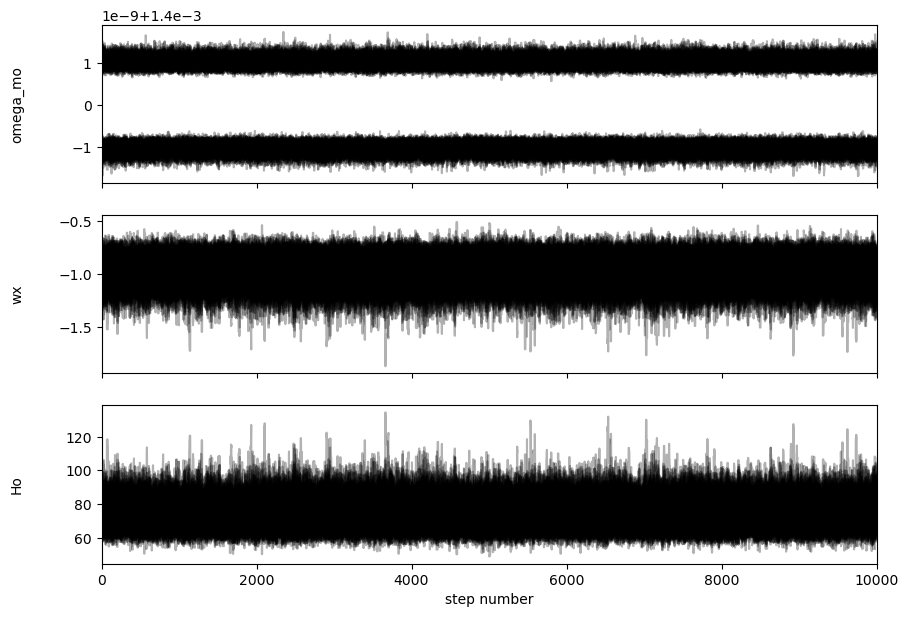

In [123]:
fig, axes = plt.subplots(3,figsize =(10,7),sharex=True)
samples = sampler.get_chain()
labels = ["omega_mo","wx","Ho"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:,:,i],"k",alpha= 0.3)
    ax.set_xlim(0,len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1,0.5)
    axes[-1].set_xlabel("step number");

In [125]:
tau = sampler.get_autocorr_time()
print(tau)

[53.19769497 78.45635242 77.67301198]


In [126]:
samples.shape

(10000, 200, 3)

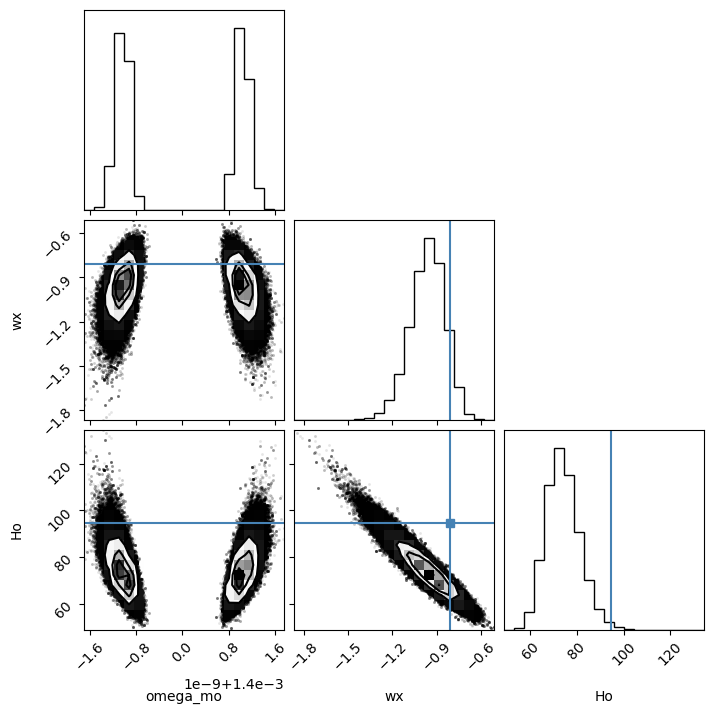

In [129]:
import corner
flat_samples = sampler.get_chain(flat =True)
#ranges = [(0,1),(-2,0.5),(50,85)]
fig = corner.corner(flat_samples,labels = labels ,truths = soln.x);

In [131]:
from IPython.display import display,Math
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:,i],[15.87, 50, 84.13])
    q= np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1],q[0],q[1],labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [133]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import sys,os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots,MCSamples
import getdist
import matplotlib.pyplot as plt
import IPython
print('GetDist Version :%s ,Matplotlib version:%s'%(getdist.__version__,plt.matplotlib.__version__))    

GetDist Version :1.4.6 ,Matplotlib version:3.8.0


In [135]:
names = ["omega_mo2","wx2","Ho"]
labels = ["Omega_mo","wx","Ho"]
samples2 = MCSamples(samples=flat_samples,names=names,labels=labels)

Removed no burn in


In [137]:
means = samples2.getMeans()
stats = samples2.getMargeStats()
conf_levels = samples2.contours

In [138]:
print(means)
mcmc

[ 1.39999998e-03 -9.64099795e-01  7.40892346e+01]


array([66.94549646, 73.50861127, 81.19074935])

In [141]:
lims0 = stats.parWithName('omega_mo2').limits
lims1 = stats.parWithName('wx2').limits
lims2 = stats.parWithName('Ho').limits

In [143]:
for conf,lim0,lim1 in zip(samples2.contours,lims0,lims1):
    #print(lim.lower,mcmc1[1])
    if conf != 0.6827:
        continue
        print('value: %.3f,lower: %.3f,upper: %.3f'%(means[0],lim0.lower-means[0],lim.upper-means[0]))
        print('value: %.2f,lower: %.2f,upper: %.2f'%(means[1],lim0.lower-means[1],lim.upper-means[1]))
        print('value: %.1f,lower: %.1f,upper: %.1f'%(means[2],lim0.lower-means[2],lim.upper-means[2]))

<Figure size 600x450 with 0 Axes>

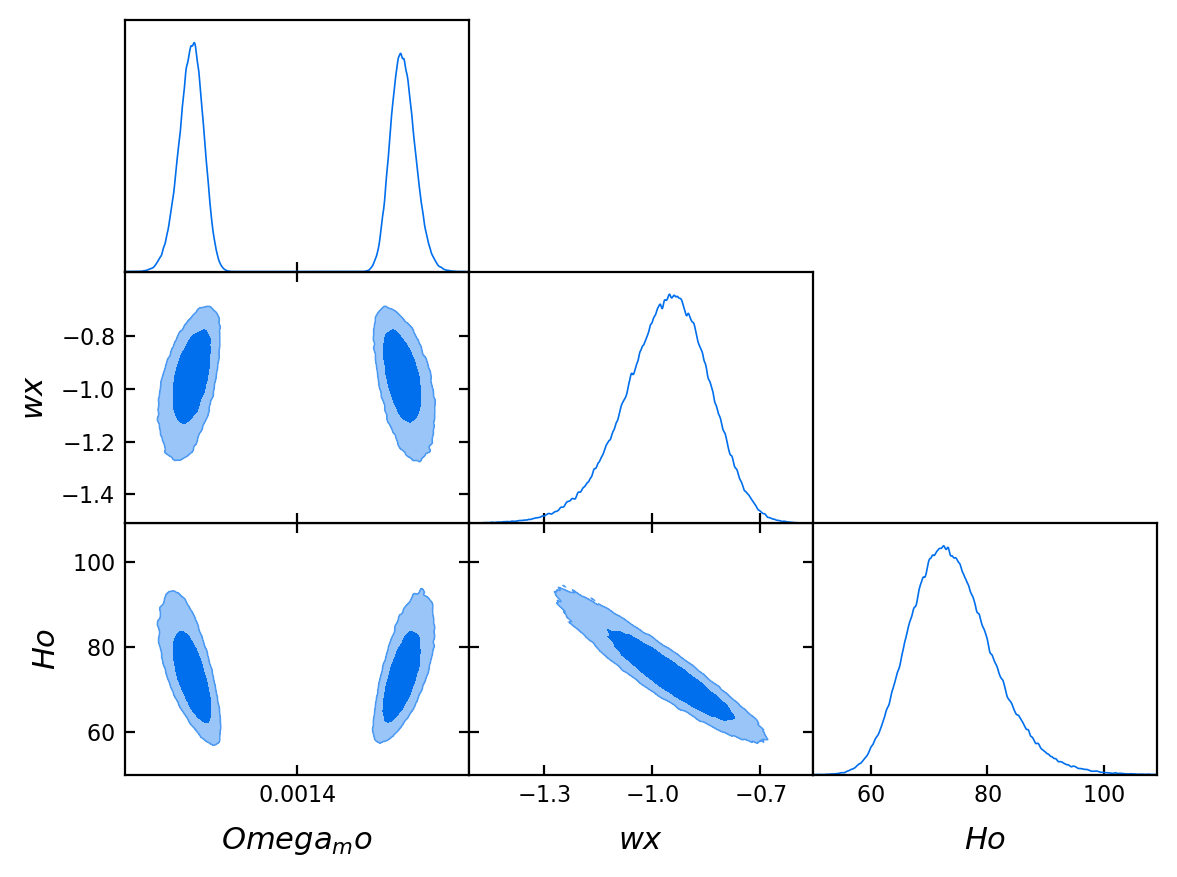

In [145]:
g = plots.get_single_plotter()
samples2.updateSettings({'contours':[0.6827,0.9545,0.9973]})
g.settings.num_plot_contours = 2
#g.settings.fine_bins_2D =200
g.triangle_plot([samples2],filled= True);